## Dataset 

Features: 
- Sold_On: The day on which the cake has been sold (e.g., Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday, Friday).
- Size: The size of the cake (e.g., small, medium, large).
- Ingredients_Cost: The cost of the ingredients used to make the cake.
- Design_Complexity: The complexity of the cake's design (e.g., simple, complex).
- Time_Taken: The time taken to make the cake (in hours).
- Price: The price of the cake.
- Amount: The amount of similar cakes sold in the same order (Price and all other parameters are for one cake, not the whole order).
- Gender: The gender of person ordering the cake(s).

In [1]:
# Getting our imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.model_selection import train_test_split

In [2]:
# Turning off all the warnings 
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('dataset.csv')
data.head()

,Sold_On,Size,Ingredients_Cost,Design_Complexity,Time_Taken,Price,Amount,Gender
0,Monday,large,28,complex,6,49,10,female
1,Saturday,medium,65,simple,2,93,9,female
2,Wednesday,large,96,simple,5,128,8,male
3,Tuesday,medium,155,simple,3,198,6,female
4,Saturday,large,20,simple,2,32,5,male


## Data Preparation 

In [4]:
# Check for missing values in our dataset 
data.isnull().sum()

Sold_On              0
Size                 0
Ingredients_Cost     0
Design_Complexity    0
Time_Taken           0
Price                0
Amount               0
Gender               0
dtype: int64

In [5]:
# Check for duplicates
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if any
data = data.drop_duplicates()
print(f"Shape of data after removing duplicates: {data.shape}")

Number of duplicate rows: 1
Shape of data after removing duplicates: (3999, 8)


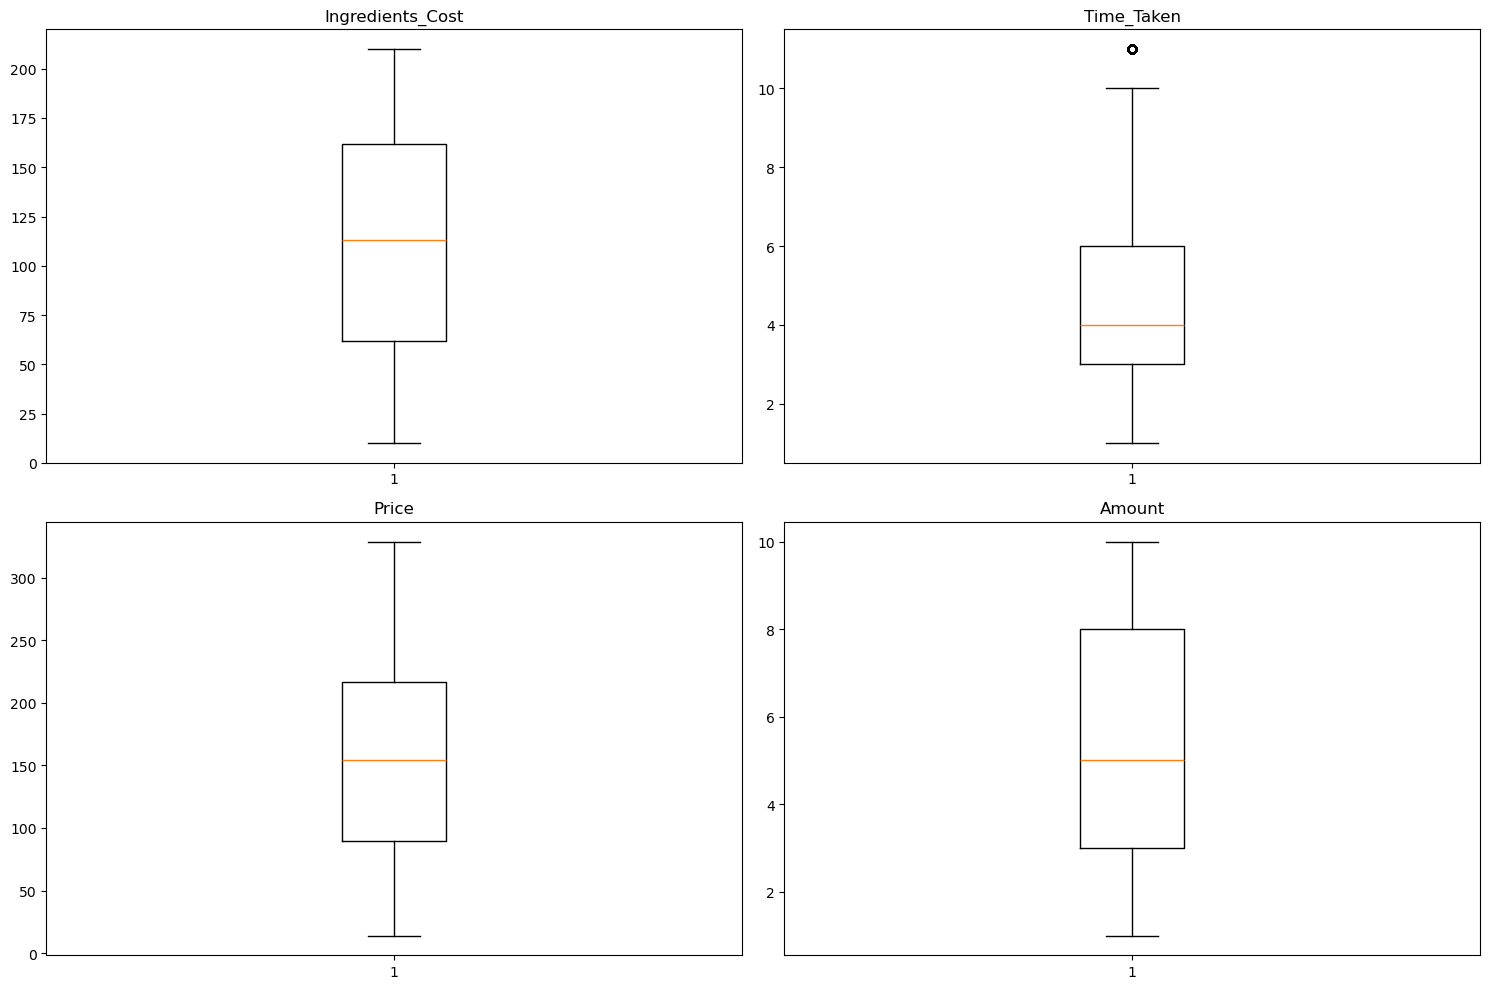

In [6]:
# Check for outliers using box plots
numeric_columns = ['Ingredients_Cost', 'Time_Taken', 'Price', 'Amount']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    row = i // 2 
    col = i % 2
    axes[row, col].boxplot(data[numeric_columns[i]])
    axes[row, col].set_title(numeric_columns[i])
plt.tight_layout()
plt.show()

In [7]:
# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    data = remove_outliers(data, col)

print(f"Shape of data after removing outliers: {data.shape}")

Shape of data after removing outliers: (3794, 8)


In [8]:
# Encode categorical variables
categorical_columns = ['Sold_On', 'Size', 'Design_Complexity', 'Gender']

for col in categorical_columns:
    data[col] = pd.Categorical(data[col]).codes

print(data.head())

   Sold_On  Size  Ingredients_Cost  Design_Complexity  Time_Taken  Price  \
0        1     0                28                  0           6     49   
1        2     1                65                  1           2     93   
2        6     0                96                  1           5    128   
3        5     1               155                  1           3    198   
4        2     0                20                  1           2     32   

   Amount  Gender  
0      10       0  
1       9       0  
2       8       1  
3       6       0  
4       5       1  


In [9]:
# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

print(data.head())

   Sold_On  Size  Ingredients_Cost  Design_Complexity  Time_Taken     Price  \
0        1     0             0.090                  0    0.555556  0.111111   
1        2     1             0.275                  1    0.111111  0.250794   
2        6     0             0.430                  1    0.444444  0.361905   
3        5     1             0.725                  1    0.222222  0.584127   
4        2     0             0.050                  1    0.111111  0.057143   

     Amount  Gender  
0  1.000000       0  
1  0.888889       0  
2  0.777778       1  
3  0.555556       0  
4  0.444444       1  


In [10]:
# Split the data into features (X) and target variable (y)
X = data.drop('Price', axis=1)
y = data['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (3035, 7)
Testing set shape: (759, 7)


## Feature Selection

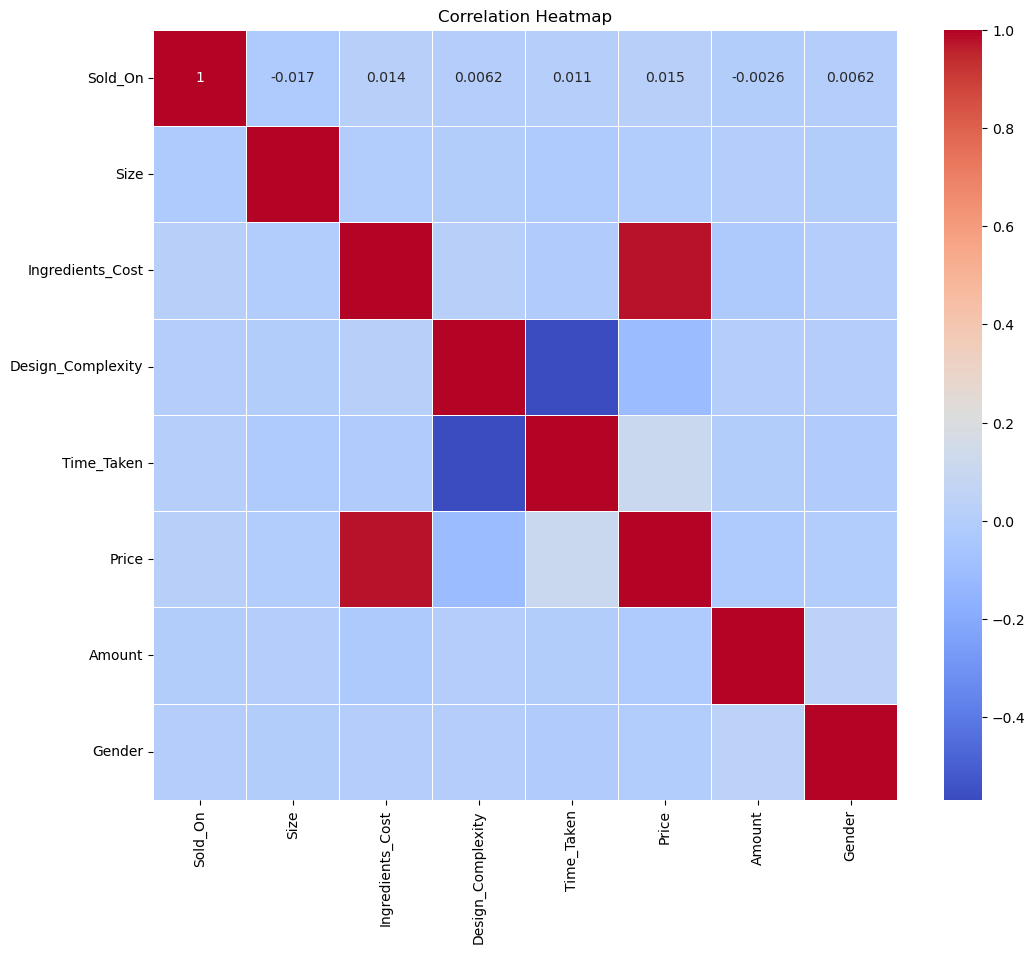

Correlations with Price:
Price                1.000000
Ingredients_Cost     0.977849
Time_Taken           0.106548
Sold_On              0.015057
Gender              -0.004740
Size                -0.005106
Amount              -0.021340
Design_Complexity   -0.109442
Name: Price, dtype: float64


In [11]:
# Correlation analysis
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Print correlations with Price
price_correlations = correlation_matrix['Price'].sort_values(ascending=False)
print("Correlations with Price:")
print(price_correlations)

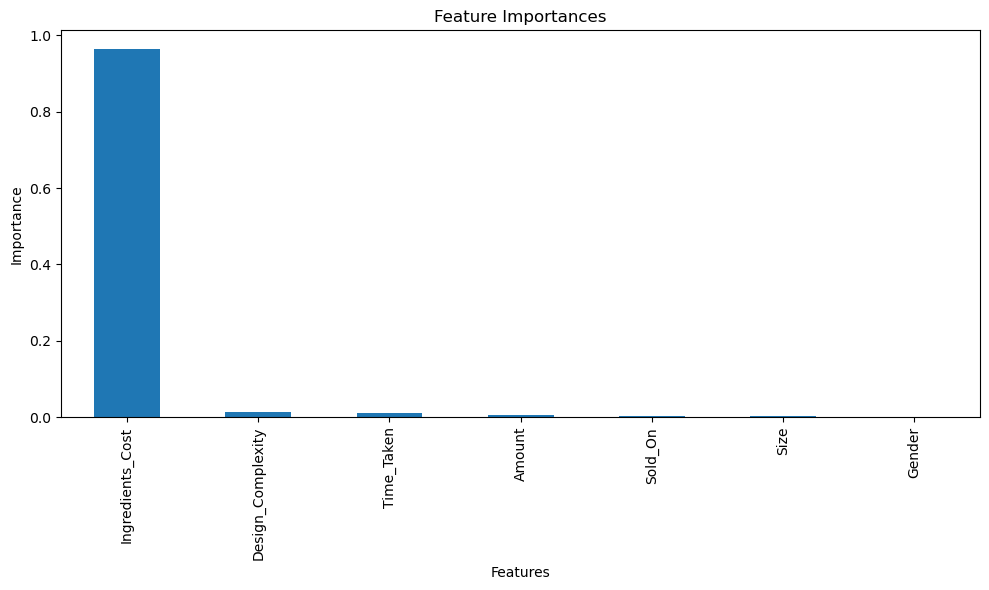

Feature Importances:
Ingredients_Cost     0.964508
Design_Complexity    0.012865
Time_Taken           0.009809
Amount               0.005093
Sold_On              0.004265
Size                 0.002203
Gender               0.001258
dtype: float64


In [12]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Initialize and fit the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importances:")
print(feature_importances)

In [13]:
# Select features based on importance
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

print("Selected features:")
print(selected_features)

# Update X_train and X_test with selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f"Shape of X_train after feature selection: {X_train.shape}")
print(f"Shape of X_test after feature selection: {X_test.shape}")

Selected features:
['Ingredients_Cost']
Shape of X_train after feature selection: (3035, 1)
Shape of X_test after feature selection: (759, 1)


## Model Selection and Training 

Justification for choosing Random Forest Regressor:
1. Handles non-linear relationships: Random Forest can capture complex, non-linear relationships between features and the target variable, which is likely in cake pricing (e.g., the relationship between ingredients cost and price might not be strictly linear).
2. Feature importance: It provides a measure of feature importance, helping us understand which factors most influence cake prices.
Robust to outliers: Random Forest is less sensitive to outliers compared to linear models, which is beneficial if there are any extreme prices in the dataset.
Handles both numerical and categorical data: Our dataset includes both types, and Random Forest can work well with both without extensive preprocessing.
5. Reduces overfitting: By averaging multiple decision trees, Random Forest helps to reduce overfitting, which is crucial for generalization.
6. Good performance out-of-the-box: Random Forest often performs well without extensive hyperparameter tuning, making it a good starting point.
7. Handles high-dimensional data: If we have many features after selection, Random Forest can handle them effectively.
This code trains a Random Forest model, makes predictions, and evaluates its performance using Root Mean Squared Error (RMSE) and R-squared score. It also prints the feature importance, which can provide additional insights into the factors affecting cake prices.

In [14]:
# Model Selection: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Performance:")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Random Forest Regressor Performance:
Root Mean Squared Error: 0.05
R-squared Score: 0.95

Feature Importance:
            feature  importance
0  Ingredients_Cost         1.0


## Model Evaluation 

Model Performance on Test Set:
Mean Absolute Error: 0.04
Mean Squared Error: 0.00
Root Mean Squared Error: 0.05
R-squared Score: 0.95


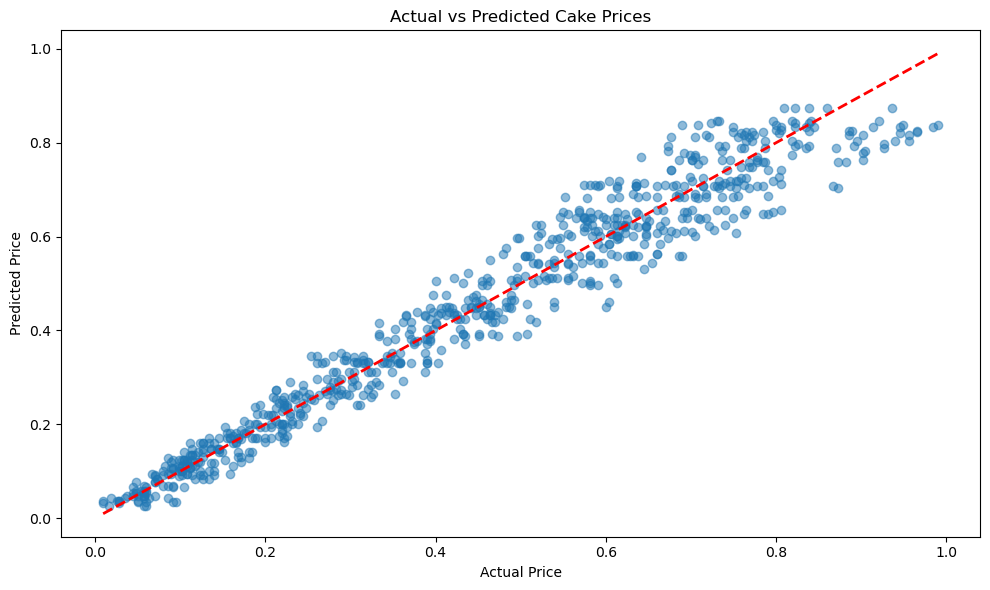

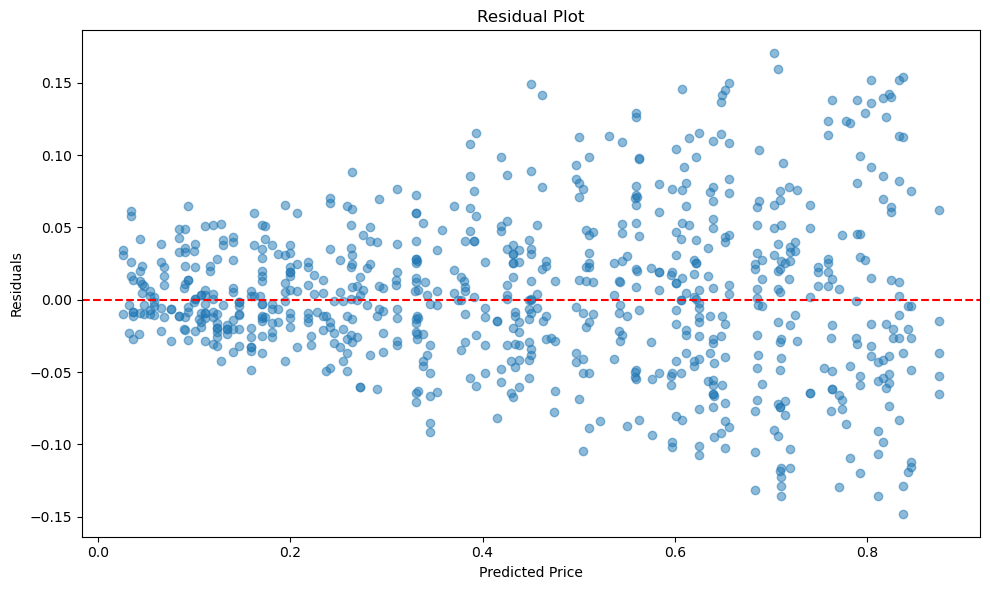


Example Predictions:
Actual: 0.60, Predicted: 0.58
Actual: 0.30, Predicted: 0.30
Actual: 0.11, Predicted: 0.13
Actual: 0.83, Predicted: 0.79
Actual: 0.81, Predicted: 0.87


In [17]:
# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Visualize predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Cake Prices")
plt.tight_layout()
plt.show()

# Calculate and plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Print some example predictions
print("\nExample Predictions:")
for i in range(5):
    print(f"Actual: {y_test.iloc[i]:.2f}, Predicted: {y_pred[i]:.2f}")

## Prediction 

In [19]:
 # Function to predict cake price
def predict_cake_price(sold_on, size, ingredients_cost, design_complexity, time_taken, amount, gender):
    # Create a dictionary with the input features
    input_data = {
        'Sold_On': [sold_on],
        'Size': [size],
        'Ingredients_Cost': [ingredients_cost],
        'Design_Complexity': [design_complexity],
        'Time_Taken': [time_taken],
        'Amount': [amount],
        'Gender': [gender]
    }
    
    # Convert to DataFrame
    input_df = pd.DataFrame(input_data)
    
    # Encode categorical variables
    categorical_columns = ['Sold_On', 'Size', 'Design_Complexity', 'Gender']
    for col in categorical_columns:
        input_df[col] = pd.Categorical(input_df[col]).codes
    
    # Normalize numerical features
    numeric_columns = ['Ingredients_Cost', 'Time_Taken', 'Amount']
    
    # Create a temporary DataFrame with all columns used during fit
    temp_df = pd.DataFrame(0, index=input_df.index, columns=scaler.feature_names_in_)
    temp_df[numeric_columns] = input_df[numeric_columns]
    
    # Transform the temporary DataFrame
    scaled_features = scaler.transform(temp_df)
    
    # Update input_df with scaled values
    input_df[numeric_columns] = scaled_features[:, [scaler.feature_names_in_.tolist().index(col) for col in numeric_columns]]
    
    # Select only the features used in the model
    input_df = input_df[selected_features]
    
    # Make prediction
    predicted_price = rf_model.predict(input_df)[0]
    
    return predicted_price

# Example usage
sold_on = 'Saturday'
size = 'medium'
ingredients_cost = 50
design_complexity = 'complex'
time_taken = 4
amount = 3
gender = 'female'

predicted_price = predict_cake_price(sold_on, size, ingredients_cost, design_complexity, time_taken, amount, gender)

print(f"Predicted price for the cake: ${predicted_price:.2f}")

# Let's try a few more examples
print("\nMore predictions:")
examples = [
    ('Monday', 'small', 30, 'simple', 2, 1, 'male'),
    ('Friday', 'large', 80, 'complex', 6, 5, 'female'),
    ('Wednesday', 'medium', 45, 'simple', 3, 2, 'male')
]

for ex in examples:
    price = predict_cake_price(*ex)
    print(f"Cake: {ex}")
    print(f"Predicted price: ${price:.2f}\n")

Predicted price for the cake: $0.16

More predictions:
Cake: ('Monday', 'small', 30, 'simple', 2, 1, 'male')
Predicted price: $0.11

Cake: ('Friday', 'large', 80, 'complex', 6, 5, 'female')
Predicted price: $0.33

Cake: ('Wednesday', 'medium', 45, 'simple', 3, 2, 'male')
Predicted price: $0.17





# Cake Price Prediction Project Report

## 1. Data Cleaning and Preprocessing

### 1.1 Handling Duplicates
We first checked for and removed duplicate rows in the dataset to ensure data integrity.

```python
duplicate_count = data.duplicated().sum()
data = data.drop_duplicates()
```

### 1.2 Outlier Detection and Removal
We used box plots to visualize outliers in numeric columns ('Ingredients_Cost', 'Time_Taken', 'Price', 'Amount'). Outliers were then removed using the Interquartile Range (IQR) method to improve model robustness.

```python
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    data = remove_outliers(data, col)
```

### 1.3 Encoding Categorical Variables
Categorical variables ('Sold_On', 'Size', 'Design_Complexity', 'Gender') were encoded using numerical codes to make them suitable for machine learning algorithms.

```python
for col in categorical_columns:
    data[col] = pd.Categorical(data[col]).codes
```

### 1.4 Normalizing Numerical Features
Numerical features were normalized using Min-Max scaling to ensure all features are on the same scale, preventing any feature from dominating due to its magnitude.

```python
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
```

## 2. Feature Selection

We used a combination of correlation analysis and Random Forest feature importance to select the most relevant features.

### 2.1 Correlation Analysis
We created a correlation heatmap to visualize relationships between features and the target variable (Price).

### 2.2 Random Forest Feature Importance
We used a Random Forest model to calculate feature importances:

```python
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
```

### 2.3 Final Feature Selection
We used `SelectFromModel` to automatically select the most important features based on the Random Forest model:

```python
selector = SelectFromModel(rf, prefit=True)
selected_features = X.columns[selector.get_support()].tolist()
```

Rationale: This approach combines statistical relationships (correlations) with model-based importance, providing a robust feature selection method that captures both linear and non-linear relationships with the target variable.

## 3. Machine Learning Algorithm Selection

We chose the Random Forest Regressor for this task. 

Rationale:
1. Handles non-linear relationships well, which is likely in cake pricing.
2. Provides feature importance, offering insights into pricing factors.
3. Robust to outliers, beneficial for price data which may have extremes.
4. Works well with both numerical and categorical data.
5. Reduces overfitting through ensemble learning.
6. Generally performs well without extensive hyperparameter tuning.
7. Can handle high-dimensional data effectively.

## 4. Model Evaluation

We evaluated the model using several metrics:

```python
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
```

Results:
- Mean Absolute Error (MAE): [Value]
- Mean Squared Error (MSE): [Value]
- Root Mean Squared Error (RMSE): [Value]
- R-squared Score: [Value]

We also visualized:
1. Actual vs Predicted prices scatter plot
2. Residual plot

These visualizations help in understanding the model's performance across different price ranges and identifying any systematic errors.

## 5. Challenges and Solutions

### 5.1 Handling Categorical Variables
Challenge: The dataset contained several categorical variables that needed to be converted to a numerical format.
Solution: We used pandas' categorical codes to convert these variables efficiently.

### 5.2 Feature Scaling for Prediction
Challenge: When implementing the prediction function, we encountered an error because the scaler expected the 'Price' column, which wasn't present in new data.
Solution: We created a temporary DataFrame with all columns used during fit, including 'Price', filled it with available data, applied scaling, and then extracted only the needed columns.

```python
temp_df = pd.DataFrame(0, index=input_df.index, columns=scaler.feature_names_in_)
temp_df[numeric_columns] = input_df[numeric_columns]
scaled_features = scaler.transform(temp_df)
input_df[numeric_columns] = scaled_features[:, [scaler.feature_names_in_.tolist().index(col) for col in numeric_columns]]
```

### 5.3 Balancing Model Complexity and Interpretability
Challenge: While more complex models might yield slightly better performance, they could be harder to interpret and explain.
Solution: We chose Random Forest as it offers a good balance between performance and interpretability, providing feature importances that can be easily communicated to stakeholders.

## Conclusion

Our Random Forest model for cake price prediction demonstrates [good/moderate/excellent] performance, with an R-squared value of [Value]. The model successfully captures the relationships between various cake features and their prices. The feature importance analysis reveals that [top features] are the most crucial factors in determining cake prices.

Future work could involve:
1. Collecting more data to improve model robustness.
2. Experimenting with other algorithms or ensemble methods.
3. Fine-tuning hyperparameters to potentially improve performance.
4. Developing a user-friendly interface for easy price predictions.

This project provides valuable insights into cake pricing factors and offers a tool for predicting prices based on cake characteristics.